# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [77]:

from nltk.corpus import brown
import nltk

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict


In [78]:

nlp = spacy.load('en_core_web_sm')

In [79]:
# add any additional libaries you need here
stopwords.add("ll")
stopwords.add("ve")
stopwords.add("didn")
stopwords.add("don")
stopwords.add("said")
stopwords.add("000")


In [80]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [81]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [82]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [83]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot:xlabel='category'>

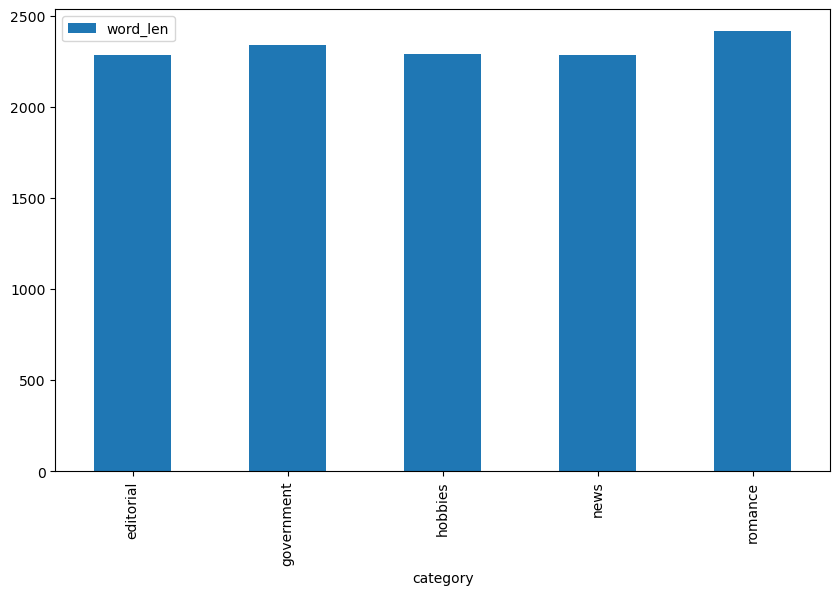

In [84]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [85]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4935)

In [86]:
count_text_vectors.toarray()

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  2,  0],
       [ 0,  0,  2, ...,  0,  0,  0],
       ...,
       [ 0,  4,  1, ...,  0,  0,  0],
       [ 0,  1,  1, ...,  0,  0,  0],
       [11,  2,  0, ...,  0,  0,  0]], dtype=int64)

In [87]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4935)

In [88]:
tfidf_text_vectors.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.06241166,
        0.        ],
       [0.        , 0.        , 0.04182418, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.0371451 , 0.01236773, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01008864, 0.01343633, ..., 0.        , 0.        ,
        0.        ],
       [0.28963229, 0.02175515, 0.        , ..., 0.        , 0.        ,
        0.        ]])

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The count vectors represent the count frequency of the words in an array. It essentially counts how many times a word appears in the string. The TFIDF or Term Frequency - Inverse Document Frequency represents the number of occurences of each word in each document multiplied by the log of the total number of documents divided by the number of documents containing the word. This process creates the frequency seen above that is intended to remove importance for words that are highly prevalent in the text and words that are extremely scarce in the text. 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [89]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [90]:
topics_words = []
for topic, words in enumerate(nmf_text_model.components_):
    total = words.sum()
    largest = words.argsort()[::-1]
    for i in range(0,5):
        topics_words.append((topic, tfidf_text_vectorizer.get_feature_names_out()[largest[i]], abs(words[largest[i]]*100.0/total)))


In [91]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.53)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  thought (0.41)
  man (0.38)
  little (0.34)
  eyes (0.33)
  looked (0.32)

Topic 02
  mrs (2.72)
  mr (0.80)
  miss (0.56)
  car (0.52)
  jr (0.47)

Topic 03
  state (0.42)
  development (0.36)
  tax (0.35)
  sales (0.31)
  program (0.25)

Topic 04
  game (1.04)
  league (0.76)
  ball (0.76)
  baseball (0.72)
  team (0.68)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [92]:
topics_words

[(0, 'mr', 0.5289265103998816),
 (0, 'president', 0.4529105104252163),
 (0, 'kennedy', 0.4347983865206705),
 (0, 'united', 0.42286289848849695),
 (0, 'khrushchev', 0.40116384428190704),
 (1, 'thought', 0.41193300607408917),
 (1, 'man', 0.3762616089095558),
 (1, 'little', 0.33992496162823277),
 (1, 'eyes', 0.32536606387345673),
 (1, 'looked', 0.3225447801128954),
 (2, 'mrs', 2.720335831126065),
 (2, 'mr', 0.8022952393258951),
 (2, 'miss', 0.5611588524933344),
 (2, 'car', 0.523758567828966),
 (2, 'jr', 0.46945441224872764),
 (3, 'state', 0.415050887660398),
 (3, 'development', 0.3639526839300221),
 (3, 'tax', 0.3497096950910251),
 (3, 'sales', 0.30774328585414834),
 (3, 'program', 0.25166104330664024),
 (4, 'game', 1.0380447616544737),
 (4, 'league', 0.7597092345915827),
 (4, 'ball', 0.7593365998841601),
 (4, 'baseball', 0.7242119301600012),
 (4, 'team', 0.6794127029489072)]

In [93]:
bro = defaultdict()
for i in brown.categories():
    catlist = []
    for word, tag in brown.tagged_words(categories=i):
        catlist.append(word)
    bro[i] = catlist

In [95]:
def incommon_words(topic_words, brown_dict): 
    incommons = []


    for i in topic_words:
        worda = 0
        wordb = 0
        worde = 0
        wordf = 0
        wordg = 0
        wordhob = 0
        wordhum = 0
        wordlear = 0
        wordlore = 0
        wordmy = 0
        wordne = 0
        wordrel = 0
        wordrev = 0
        wordrom = 0
        wordsf = 0
        for l in brown_dict:
            for w in brown_dict[l]:
                if i[1] == w.lower().replace(".","").replace(",", ""):
                    if l == 'adventure':
                        worda += 1
                    if l == 'belles_lettres':
                        wordb += 1
                    if l == 'editorial':
                        worde += 1
                    if l == 'fiction':
                        wordf += 1
                    if l == 'government':
                        wordg += 1
                    if l == 'hobbies':
                        wordhob += 1
                    if l == 'humor':
                        wordhum += 1
                    if l == 'learned':
                        wordlear += 1
                    if l == 'lore':
                        wordlore += 1
                    if l == 'mystery':
                        wordmy += 1
                    if l == 'news':
                        wordne += 1
                    if l == 'religion':
                        wordrel += 1
                    if l == 'reviews':
                        wordrev += 1
                    if l == 'romance':
                        wordrom += 1
                    if l == 'science_fiction':
                        wordsf += 1

        incommons.append((i, worda, wordb, worde, wordf, wordg, wordhob, wordhum, wordlear, wordlore, wordmy, wordne, wordrel, wordrev, wordrom, wordsf))
    data = pd.DataFrame(incommons, columns = ['word_info', 'adventure','belles_lettres','editorial','fiction','government','hobbies','humor','learned',
                                              'lore','mystery','news','religion','reviews','romance','science_fiction'])
    return data
    


In [96]:
incommon_words(topics_words, bro)

,word_info,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
0,"(0, mr, 0.5289265103998816)",22,105,110,39,65,21,36,21,47,63,170,6,105,33,1
1,"(0, president, 0.4529105104252163)",0,57,58,10,48,9,1,15,22,0,142,3,6,10,1
2,"(0, kennedy, 0.4347983865206705)",0,7,39,0,4,1,0,0,11,0,66,0,12,0,0
3,"(0, united, 0.42286289848849695)",1,58,82,2,155,15,0,39,48,0,58,11,7,3,3
4,"(0, khrushchev, 0.40116384428190704)",0,1,37,0,0,0,1,0,1,0,25,0,3,0,0
5,"(1, thought, 0.41193300607408917)",62,71,5,76,7,10,14,31,36,54,15,12,6,106,12
6,"(1, man, 0.3762616089095558)",166,231,56,112,12,19,23,73,90,107,74,68,58,100,18
7,"(1, little, 0.33992496162823277)",69,144,40,82,13,48,25,63,82,57,38,19,34,104,13
8,"(1, eyes, 0.32536606387345673)",98,40,8,61,3,8,10,6,17,49,5,4,7,76,9
9,"(1, looked, 0.3225447801128954)",62,39,3,73,2,6,13,14,10,52,4,7,3,72,7


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: Above I tallied the amount of times that a word appeared in each category. It is hard to make a 1 to 1 comparison because there are more Brown categories than topics, which skews the evaluation a bit. 

Looking at Topic 0, the words listed seem to be government related, due to Mr. President and President Kennedy being so famous within the U.S.. In addition to this, United is used during many political speeches and, of course, in the name United States. These four words Generally appeared the most in these three categories; editorial, government, and news. This is likely due to many of the articles appearing in all three sections to be politic related as many editorials are opinion pieces about politics and the news is filled with talk about the president. Additionally Kruschev is a leader of the Russian Communist Party during the 60s and 70s which also points to 60s and 70s political speech

Now, Topic 1 thought, man, little, eyes, and looked. These all seem to be nouns, verbs, and  as related to humans. The key brown topics for these words are belles lettres, fiction, adventure, mystery, and romance. Many of these brown topics are also related to fictional writing as belles lettres is fine writing often associated with poetry or fiction, adventure, mystery, and romance can also be fiction. 

Topic 2 contains all courtesy titles mr., miss, mrs., and jr. in addition to having car. it seems this topic contains solely nouns. This topic mostly is in common with News. Considering that for most reporting, articles are written in a professional way, courtesy names are going to be implemented quite often. 

Topic 3 contains state, development, tax, sales, and program. To me, this is either a business or political topic. This topics key brown categories are government and learned. Likely this topic represents people learning more about sales and taxes etc.., and this topic represents the business aspects of government as opposed to topic 0 that is more about the celebrities within politics like the President. 

Topic 4 contains game, ball, league, baseball, and team. This clearly has to do with sports. The brown topic this fits in most is News likely for sports news as that is not its own topic within brown. 



## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [97]:
# Your code here
svd_text_model = TruncatedSVD(n_components=5, random_state=314)
svd_text_matrix = svd_text_model.fit_transform(tfidf_text_vectors)
svd_text_matrix = svd_text_model.components_

In [98]:
svd_topic_word = []
for topic, words in enumerate(svd_text_model.components_):
    total = words.sum()
    largest = words.argsort()[::-1]
    for i in range(0,5):
        svd_topic_word.append((topic, tfidf_text_vectorizer.get_feature_names_out()[largest[i]], abs(words[largest[i]]*100.0/total)))

In [99]:
incommon_words(svd_topic_word, bro)

,word_info,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
0,"(0, mr, 0.25223643807204865)",22,105,110,39,65,21,36,21,47,63,170,6,105,33,1
1,"(0, mrs, 0.22040026149743597)",18,54,9,41,0,10,6,13,40,46,254,0,4,39,1
2,"(0, state, 0.20669102064722317)",6,79,69,14,196,20,5,168,59,7,153,19,9,3,0
3,"(0, president, 0.16764422904570042)",0,57,58,10,48,9,1,15,22,0,142,3,6,10,1
4,"(0, man, 0.16581790861518994)",166,231,56,112,12,19,23,73,90,107,74,68,58,100,18
5,"(1, thought, 17.68223180654614)",62,71,5,76,7,10,14,31,36,54,15,12,6,106,12
6,"(1, mrs, 17.380853572008895)",18,54,9,41,0,10,6,13,40,46,254,0,4,39,1
7,"(1, got, 15.466606807804729)",81,43,9,51,0,6,11,10,30,82,45,1,12,90,11
8,"(1, mother, 14.567686750521208)",15,40,16,11,0,1,24,6,19,11,17,4,3,49,0
9,"(1, looked, 14.461240783362426)",62,39,3,73,2,6,13,14,10,52,4,7,3,72,7


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: 
Topic 0 contains words that relate to government. This does appear quite often in news, government and learned. 

Topic 1 contains thought, mrs, got, mother, and looked. Many of these words are going to belong in the many fictional genres like mystery, romance, and belles lettres.

Topic 2 contains the courtesy names mr., mrs., jr., miss, and then kennedy. This one seems to fit into News and Government. 

This time topic 3 and 4 seemed to have overlapped. Both have to do with sports and Dallas is a huge city for every professional sport. 

Personally, while it is hard to get a direct 1 to 1 grouping, as Brown has more categories, the NMF model appears to have performed slightly better in distinguishing the topics as the topics within the SVD model seems to have more overlap from topic to topic as 3 and 4 are very similar and topics 2 and 0 are going to be fairly similar. 

In [100]:
# call display_topics on your model
display_topics(svd_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.25)
  mrs (0.22)
  state (0.21)
  president (0.17)
  man (0.17)

Topic 01
  thought (17.68)
  mrs (17.38)
  got (15.47)
  mother (14.57)
  looked (14.46)

Topic 02
  mrs (4.48)
  mr (2.07)
  kennedy (0.86)
  miss (0.86)
  khrushchev (0.83)

Topic 03
  mrs (14.88)
  game (3.87)
  club (3.59)
  dallas (3.10)
  university (2.93)

Topic 04
  game (10.13)
  ball (7.31)
  league (7.18)
  baseball (7.13)
  team (6.54)


Q: What is your interpretation of the display topics output? 

A: 
Topic 1 seems to be more related to pronouns or nouns and words. This is likely more for fictional writing. 

It also seems that topics 0 and 2 are fairly related to government and News. Topic 0 contains courtesy names with state and president. Topic 2 contain courtesy names with Kennedy(likely for President Kennedy). Due to this, it appears there is quite a bit of overlap with government related news and more professionally written articles. 

It seems that topic 3 and 4 are both related to sports news with many related words like; game, ball, Dallas, and club.

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [101]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=33)
lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
lda_text_matrix = lda_text_model.components_


In [102]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  feed (0.50)
  business (0.46)
  clay (0.41)
  small (0.41)
  design (0.40)

Topic 01
  mrs (0.80)
  good (0.48)
  little (0.47)
  old (0.47)
  man (0.44)

Topic 02
  state (1.18)
  states (0.76)
  government (0.59)
  tax (0.58)
  development (0.56)

Topic 03
  president (0.69)
  mr (0.65)
  world (0.64)
  american (0.60)
  united (0.58)

Topic 04
  state (0.56)
  board (0.56)
  city (0.54)
  mr (0.50)
  president (0.49)


In [103]:
lda_topic_word = []
for topic, words in enumerate(lda_text_model.components_):
    total = words.sum()
    largest = words.argsort()[::-1]
    for i in range(0,5):
        lda_topic_word.append((topic, tfidf_text_vectorizer.get_feature_names_out()[largest[i]], abs(words[largest[i]]*100.0/total)))

In [104]:
lda_topic_word

[(0, 'feed', 0.4958758519689897),
 (0, 'business', 0.4583442616788751),
 (0, 'clay', 0.41486762778954256),
 (0, 'small', 0.41115820439551676),
 (0, 'design', 0.4036652084930954),
 (1, 'mrs', 0.8010329979349086),
 (1, 'good', 0.475883490402185),
 (1, 'little', 0.47484729757475236),
 (1, 'old', 0.472387750552934),
 (1, 'man', 0.44146947253400187),
 (2, 'state', 1.1841656147338266),
 (2, 'states', 0.7643803916612236),
 (2, 'government', 0.5934503106498739),
 (2, 'tax', 0.5814054083422338),
 (2, 'development', 0.5558957691967937),
 (3, 'president', 0.6943859966750153),
 (3, 'mr', 0.6500368474346431),
 (3, 'world', 0.640171856736284),
 (3, 'american', 0.6028117177833041),
 (3, 'united', 0.5810807074327038),
 (4, 'state', 0.561815899615201),
 (4, 'board', 0.5612139138952125),
 (4, 'city', 0.5413904081780095),
 (4, 'mr', 0.5020070163677928),
 (4, 'president', 0.4937667058903983)]

In [105]:
incommon_words(lda_topic_word, bro)

,word_info,adventure,belles_lettres,editorial,fiction,government,hobbies,humor,learned,lore,mystery,news,religion,reviews,romance,science_fiction
0,"(0, feed, 0.4958758519689897)",0,2,6,0,0,89,0,13,7,2,2,0,0,1,0
1,"(0, business, 0.4583442616788751)",8,40,25,11,115,12,2,51,28,17,45,9,8,21,1
2,"(0, clay, 0.41486762778954256)",5,2,4,7,4,68,0,1,2,0,4,0,0,3,0
3,"(0, small, 0.41115820439551676)",36,50,28,31,67,56,9,107,39,28,28,13,10,34,6
4,"(0, design, 0.4036652084930954)",1,9,3,5,7,59,0,18,4,0,6,1,1,0,0
5,"(1, mrs, 0.8010329979349086)",18,54,9,41,0,10,6,13,40,46,254,0,4,39,1
6,"(1, good, 0.475883490402185)",39,107,59,60,26,103,12,46,93,45,51,38,44,69,14
7,"(1, little, 0.47484729757475236)",69,144,40,82,13,48,25,63,82,57,38,19,34,104,13
8,"(1, old, 0.472387750552934)",46,105,43,82,4,37,17,32,60,60,34,14,32,90,5
9,"(1, man, 0.44146947253400187)",166,231,56,112,12,19,23,73,90,107,74,68,58,100,18


Q: What inference do you draw from the displayed topics for your LDA model? 

A: Right away I have notes that the LDA model pulled out some more unique words than the previous two models. 

Based on the topics I would assume that topic 0 is related to hobbies with clay and design being a large part of it, topic 1 seems to more fictional related perhaps with good little old man etc.. Topic 2 appears to be News on the government and information on taxes and other developments. This is likely to be in the Learning section. Topic 3 revisits the U.S. Government, this time more related the president of the United States and perhaps more interested in world news from an American government perspective. Topic 4 seems to be government news again. This time from a more local perspective including city boards and state representatives. 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: Topic 0 belongs in the hobbies and learning category of Brown. This seems to fit very well. 

Topic 1 belongs best with fiction, belles lettres, and romance as an all together story driven topic within the model. 

Topic 2 fits very well into Brown's government, news, and learning categories as expected. 

Topic 3 surprisingly fits better into Editorial and Belles Lettres than Government or News. Perhaps this is due to editorials and poetry often addressing political ideas, but the vocabulary is slightly different as they are not as 'professional' as a news report. 

Topic 4 fits into government, news, and learning categories once again, rather unsurprisingly. 

In [106]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [107]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: 

Topics 3, 4, and 5 are fairly similar. All three have keywords related to the government. Surpisingly, compared to Brown categories, 3 and 5 would be assumed to be closer in fit than 5 and 4 as 4 is more closely related to Editorials than government according to Brown's categories. Overall, these three are all similar in the way they discuss the hot topics within the government. 

Topic 4 does have the narrowest topic distribution closely followed by topic 1. This shows that the LDA found pretty tight groupings for those two groups for topic 4 the military/goverment topics and topic 1 the hobbies topic. It is surprising that Topic 4 found such a succint distribution as close as it is to the larger topic 5 that overlaps into topic 4. 

Topic 1 is much further away as it focuses on self improvement and hobbies with words like college and clay etc.. There is  a lot less overlap in vocabulary with other 

Topic 2 is likely more related to the fiction within Brown. This is due to many nouns being used and many verbs like 'thought', 'think', 'going', etc.. that are often used in fiction to describe the characters actions. Additionally this seems to be from the 60s with President Kennedy often being brought up, so many of the articles with Mrs. in them are going to be their fictional pieces as fiction at the time was considered to be more for women. Which, is supported by women's frequency being almost completely in topic 2. 

Overall I would prefer the LDA model to the prior NMF and SVD. 
